## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import netCDF4 as nc
import glob
import datetime
from datetime import timedelta
from collections import defaultdict 
from netCDF4 import Dataset as NetCDFFile 
from datetime import datetime, timedelta
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans, SpectralClustering
from scipy import signal
import xarray as xr
import pylab
import operator
import pickle as pkl
import mpl_toolkits
mpl_toolkits.__path__.append('/home/ninow/packages/basemap-1.1.0/')
from mpl_toolkits.basemap import Basemap

## Define Helper Methods

In [2]:
# generate a dictionary {station_id -> formatted_staion_name}
def get_station_dict():
    observation_data = nc.Dataset(observations)
    station_name_dict = {}
    for i in range(observation_data['station'].size):
        try:
            name = b''.join(list(observation_data['name'][i].compressed())).decode('utf-8')
        except AttributeError:
            name = b''.join(list(observation_data['name'][i])).decode('utf-8')
        station_name_dict[i] = name
    return station_name_dict

# plot the map of switzerland as background image
def plot_map(ax, rlat_min, rlat_max, rlon_min, rlon_max):
    dd = xr.open_dataset(time_invariant_grid_data_path)
    dd.set_coords(["rlon", "rlat"], inplace=True)
    swiss_data = dd.sel(rlon=slice(rlon_min, rlon_max), rlat=slice(rlat_min, rlat_max))
    swiss_data.FR_LAND.isel(time = 0).plot.pcolormesh("rlon", "rlat", alpha=0.8, cmap=plt.cm.get_cmap('GnBu_r'), add_colorbar=False)
    swiss_data.HH.isel(time = 0).plot.pcolormesh("rlon", "rlat", alpha=0.6, cmap=plt.cm.get_cmap('YlGn'), add_colorbar=False)

# get time axis for plot
def get_time_axis(data_length, year_length):
    start=datetime.strptime('15100100', '%y%m%d%H')
    x_times = [start + timedelta(hours=t*3) for t in range(data_length)]
    return [x_times[i:i + year_length] for i in range(0, data_length, year_length)]

# filter out all corrupted measurements
def get_filtered_data(x,data):
    if len(x) != len(data):
        raise Exception('Timedate array and data do not have the same length!')
    return zip(*[(x_,d) for x_,d in zip(x,data) if d < 1e10])

def getErrorPerStation(distance_metric, baseline):
    if distance_metric == '2d':
        error_data_set = error_statistic_per_run_dict_2d
    elif distance_metric == '3d':
        error_data_set = error_statistic_per_run_dict_3d
    # calculate MAE per station for station/hour/month/bias-corrected baseline
    mean_absolute_error_data_per_run = None
    for run in range(3):
        error_data = error_data_set['run_%s' % run].error_statistic.sel(error_type = baseline)
        mean_error_data = np.nanmean(np.absolute(error_data), axis=(0,1,3,4,5))
        try:
            mean_absolute_error_data_per_run = np.concatenate((mean_absolute_error_data_per_run, mean_error_data[None,:]),
                                                              axis=0)
        except:
            mean_absolute_error_data_per_run = mean_error_data[None,:]

    mean_absolute_error_per_station = np.nanmean(mean_absolute_error_data_per_run,axis=0)

    # calculate RMSE per station for station/hour/month/bias-corrected baseline
    rmse_data_per_run = None
    for run in range(3):
        error_data = error_data_set['run_%s' % run].error_statistic.sel(error_type = baseline)
        mean_error_data = np.sqrt(np.nanmean(np.square(error_data), axis=(0,1,3,4,5)))
        try:
            rmse_data_per_run = np.concatenate((rmse_data_per_run, mean_error_data[None,:]), axis=0)
        except:
            rmse_data_per_run = mean_error_data[None,:]

    rmse_per_station = np.nanmean(rmse_data_per_run, axis=0)

    return mean_absolute_error_per_station, rmse_per_station

month_dict={0:'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 8:'Sept', 9:'Okt', 10:'Nov', 11:'Dec'}

## Define Constants

In [12]:
# paths for data and plots
baseline_experiment_path ='/mnt/ds3lab-scratch/ninow/final_results/baseline/bias_corrected_baseline/'
observations_path = '/mnt/ds3lab-scratch/ninow/observations/meteoswiss_t2m_20151001-20180331.nc'
time_invariant_grid_data_path = '/mnt/ds3lab-scratch/ninow/topo/topodata.nc'
destination = '/home/ninow/master_thesis/code/project/results/baseline/final_plots'

## Load Data

In [13]:
# gather all models in source folder
# 2d distance baseline
error_statistic_per_run_dict_2d = {}
for path in glob.glob(baseline_experiment_path + '/2d_distance/**/experiment_statistic.pkl', recursive=True):
    run = path[-30:-25]
    with open(path, 'rb') as file:
        ds = pkl.load(file)
    error_statistic_per_run_dict_2d[run] = ds

In [14]:
# 3d distance baseline
error_statistic_per_run_dict_3d = {}
for path in glob.glob(baseline_experiment_path + '/3d_distance/**/experiment_statistic.pkl', recursive=True):
    run = path[-30:-25]
    with open(path, 'rb') as file:
        ds = pkl.load(file)
    error_statistic_per_run_dict_3d[run] = ds

In [6]:
# 3NN baseline
error_data_3nn = {}
for i in range(3):
    with open('/mnt/ds3lab-scratch/ninow/final_results/baseline/knn_regression/knn_3/knn_errors_per_lead_run_%s.pkl' % i, 'rb') as handle:
        error_data_3nn['run_%s' % i] = pkl.load(file=handle)

In [7]:
# 10NN baseline
error_data_10nn = {}
for i in range(3):
    with open('/mnt/ds3lab-scratch/ninow/final_results/baseline/knn_regression/knn_10/knn_errors_per_lead_run_%s.pkl' % i, 'rb') as handle:
        error_data_10nn['run_%s' % i] = pkl.load(file=handle)

In [18]:
# load prediction error from prediction run
prediction_error = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/model_run_error.pkl', 'rb'))

In [9]:
# load station positions to plot them on map
station_data = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/station/grid_size_1/time_invariant_data_per_station.pkl','rb'))
station_positions = station_data.station_position.sel(positinal_attribute = ['rlat', 'rlon','height_raw'])
stations = station_data.station
station_names = station_data.station_name

station_idx_mapping = {}
for s_idx, s in enumerate(stations.data):
    station_idx_mapping[s] = s_idx

In [10]:
topo_features_per_station = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/station/grid_size_1/time_invariant_data_per_station.pkl','rb'))

In [25]:
# time invariant observation data
OBS = xr.open_dataset(observations_path)

In [26]:
# get all station ids
stations = OBS.station_id.data

# time invarioant (x,y,z)-coordiantes of stations
station_x, station_y = [],[]
for s in stations:
    OBS_station = OBS.sel(station_id = s)
    station_x += [OBS_station.rlon.item()]
    station_y += [OBS_station.rlat.item()]

## Plot Mean Absolute Error Per Station on Map

In [ ]:
mean_absolute_error_per_station_baseline, rmse_per_station_baseline = getErrorPerStation(distance_metric='3d', baseline='error')

In [13]:
# get min and max error with the corresponding station
best_station, worst_station = stations[np.argmin(mean_absolute_error_per_station_baseline)], stations[np.argmax(mean_absolute_error_per_station_baseline)]
print('Best Station: %s with MAE = %s' % (OBS.sel(station_id = best_station).name.data, np.min(mean_absolute_error_per_station_baseline)))
print('Worst Station: %s with MAE = %s' % (OBS.sel(station_id = worst_station).name.data, np.max(mean_absolute_error_per_station_baseline)))
print('MAE of all Stations = %s, Std. Dev. = %s' % (np.mean(mean_absolute_error_per_station_baseline), np.std(mean_absolute_error_per_station_baseline)))

Best Station: b'Chasseral' with MAE = 0.9043426644404852
Worst Station: b'La Br\xc3\xa9vine' with MAE = 2.924152175234448
MAE of all Stations = 1.6833719748708371, Std. Dev. = 0.4469998331351214


In [15]:
str(OBS.sel(station_id = 35).name.item())

"b'S\\xc3\\xa4ntis'"

/home/ninow/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


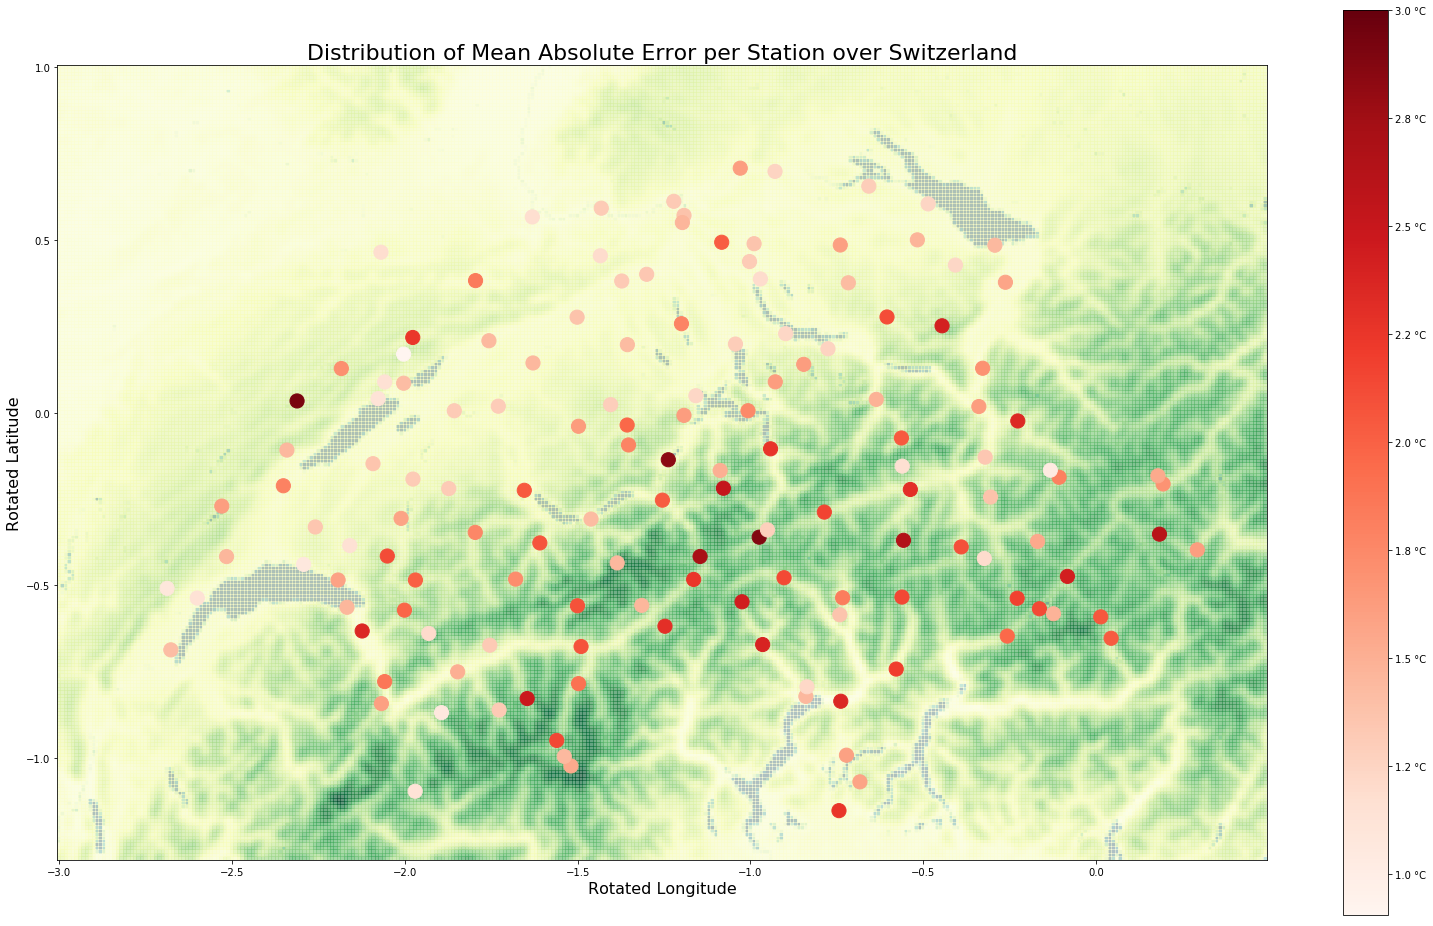

In [43]:
#-------------------------------------------------------------------------------------------------------------------------
# Plot station by error on map
#-------------------------------------------------------------------------------------------------------------------------
rlat_min, rlat_max, rlon_min, rlon_max = -1.3, 1, -3, 0.5

# plot the absolute error of each station in a heat map
fig = plt.figure(figsize=(22,13))
ax = fig.add_subplot(111)
plot_map(ax, rlat_min, rlat_max, rlon_min, rlon_max)
cax = ax.scatter(station_x, station_y, c=mean_absolute_error_per_station_baseline, s=200,
                 cmap='Reds', norm=mpl.colors.Normalize(vmin=np.min(mean_absolute_error_per_station), vmax=3))
cbar = plt.colorbar(cax, format=ticker.FuncFormatter(lambda x, pos: "%.1f °C" % x))
ax.set_title('Distribution of Mean Absolute Error per Station over Switzerland', fontsize=22)
ax.grid('off')
plt.axis('scaled')
plt.xlabel('Rotated Longitude', fontsize=16)
plt.ylabel('Rotated Latitude', fontsize=16)
plt.tight_layout()
plt.savefig(destination + '/mean_absolute_error_per_station_on_map.png')
plt.show()
plt.close()

# Error distribution by model

In [125]:
mean_absolute_error_model = np.absolute(prediction_error.sel(data = 'difference'))

### Plot error by station on map

In [121]:
mean_absolute_error_per_station_model = np.mean(mean_absolute_error_model),axis=0)

In [119]:
# time invariant observation data
OBS = xr.open_dataset(observations_path)

In [120]:
# get all station ids
stations = OBS.station_id.data

# time invarioant (x,y,z)-coordiantes of stations
station_x, station_y = [],[]
for s in stations:
    OBS_station = OBS.sel(station_id = s)
    station_x += [OBS_station.rlon.item()]
    station_y += [OBS_station.rlat.item()]

/home/ninow/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


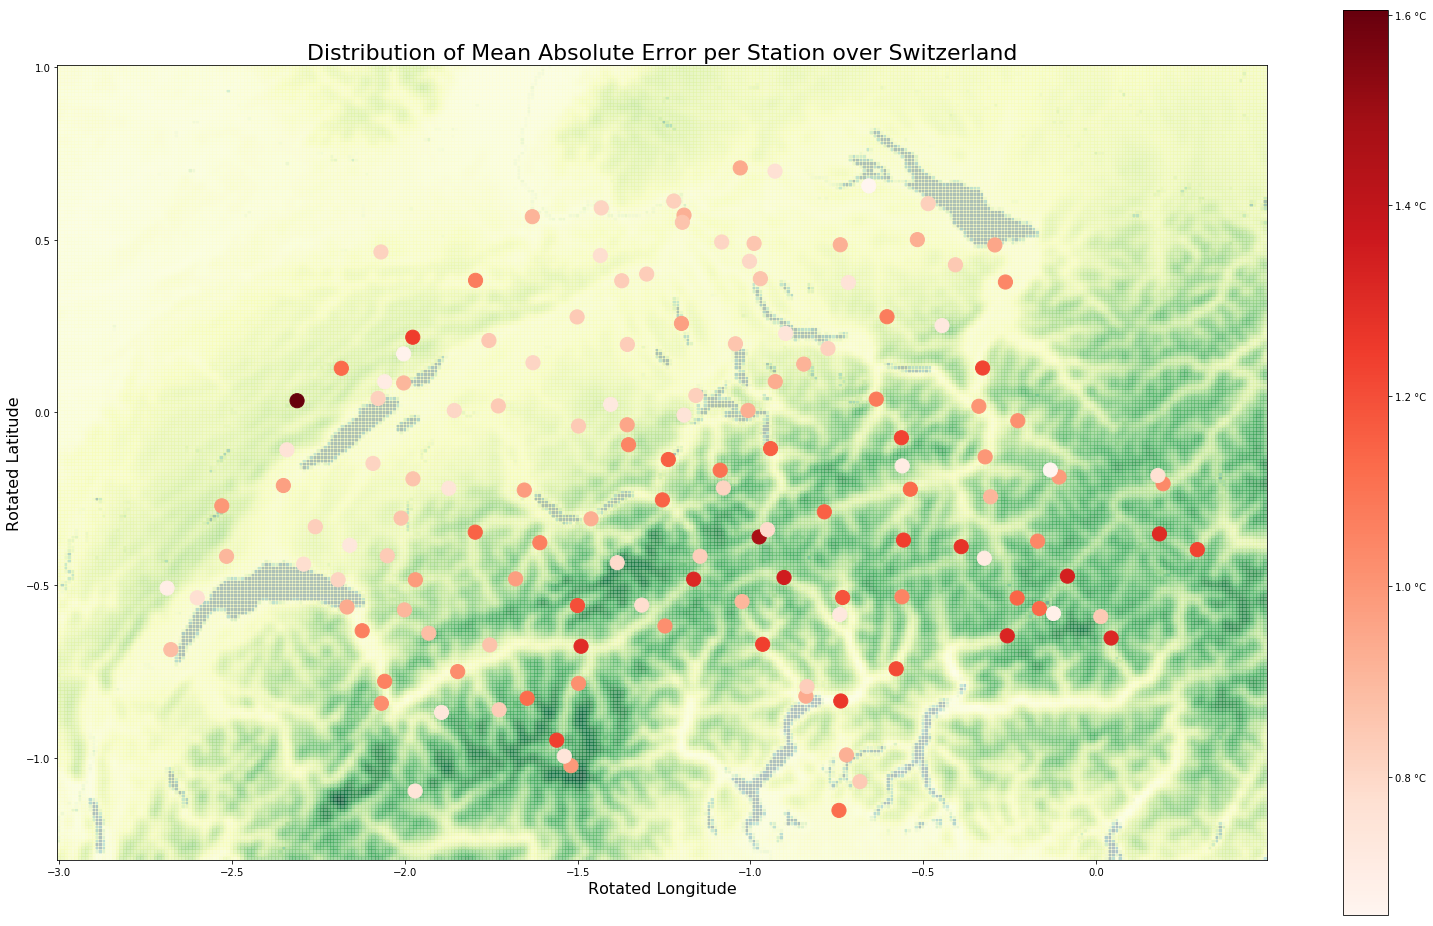

In [201]:
#-------------------------------------------------------------------------------------------------------------------------
# Plot station by error on map
#-------------------------------------------------------------------------------------------------------------------------
rlat_min, rlat_max, rlon_min, rlon_max = -1.3, 1, -3, 0.5

# plot the absolute error of each station in a heat map
fig = plt.figure(figsize=(22,13))
ax = fig.add_subplot(111)
plot_map(ax, rlat_min, rlat_max, rlon_min, rlon_max)
cax = ax.scatter(station_x, station_y, c=mean_absolute_error_per_station_model, s=200,
                 cmap='Reds', norm=mpl.colors.Normalize(vmin=np.min(mean_absolute_error_per_station_model), vmax=np.max(mean_absolute_error_per_station_model)))
cbar = plt.colorbar(cax, format=ticker.FuncFormatter(lambda x, pos: "%.1f °C" % x))
ax.set_title('Distribution of Mean Absolute Error per Station over Switzerland', fontsize=22)
ax.grid('off')
plt.axis('scaled')
plt.xlabel('Rotated Longitude', fontsize=16)
plt.ylabel('Rotated Latitude', fontsize=16)
plt.tight_layout()
plt.savefig(destination + '/mean_absolute_error_per_station_on_map.png')
plt.show()
plt.close()

### Plot error by height difference

In [205]:
mean_absolute_error_per_station_model

<xarray.DataArray 'run_0' (station: 144)>
array([1.004406, 0.654612, 0.940772, 1.070901, 1.071804, 1.229475, 0.914682,
       1.472083, 1.145532, 0.986807, 0.86364 , 0.703203, 0.847387, 0.809592,
       1.016948, 1.199884, 1.209408, 0.847269, 1.131126, 1.22809 , 0.986267,
       0.997978, 1.313178, 1.338133, 1.040437, 0.698258, 0.812305, 0.791672,
       0.846221, 0.728839, 1.224535, 1.068513, 0.841997, 0.820946, 0.866435,
       1.234012, 0.670228, 0.751312, 1.152454, 1.312151, 1.352922, 0.922104,
       0.723358, 1.026418, 1.262545, 0.824318, 1.115946, 0.931526, 1.153637,
       0.848526, 1.081556, 0.887441, 0.855467, 0.791475, 0.780101, 0.750062,
       0.975625, 1.297791, 1.127021, 0.778733, 0.83378 , 0.826578, 1.107422,
       0.769143, 0.863614, 1.052607, 0.654918, 0.68457 , 0.911119, 0.77482 ,
       0.757877, 0.846969, 0.827449, 0.839943, 0.746776, 0.922286, 0.803418,
       0.936883, 0.923308, 0.805011, 0.83213 , 0.837784, 0.828136, 0.832486,
       1.185693, 0.810212, 0.75563

In [211]:
station_height = topo_features_per_station.grid_data.sel(feature = 'HH').squeeze()
station_height_difference = topo_features_per_station.grid_data.sel(feature = 'HH_DIFF').squeeze()

### Plot error of model per hour

In [164]:
error_per_hour = {}
for idx, error_for_init in enumerate(mean_absolute_error_model):
    hour = error_for_init.init.item()[-2:]
    try:
        error_per_hour[int(hour)] += list(error_for_init.data)
    except:
        error_per_hour[int(hour)] = list(error_for_init.data)

In [165]:
mean_absolute_error_per_hour = np.zeros(24)
for item in error_per_hour.items():
    hour = (item[0] + 1) % 24
    mean_absolute_error_per_hour[hour] = np.nanmean(item[1])

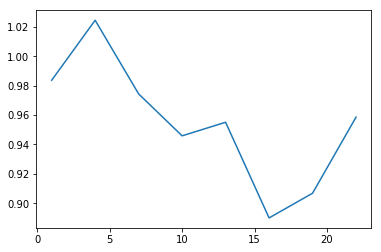

In [166]:
hours = np.arange(1,24,3)
plt.plot(hours, mean_absolute_error_per_hour[hours])
plt.show()

### Plot error of model per month

In [202]:
error_per_month = {}
for idx, error_for_init in enumerate(mean_absolute_error_model):
    month = int(error_for_init.init.item()[2:4])-1
    try:
        error_per_month[int(month)] += list(error_for_init.data)
    except:
        error_per_month[int(month)] = list(error_for_init.data)

In [203]:
mean_absolute_error_per_month = np.zeros(12)
for item in error_per_month.items():
    month = item[0]
    mean_absolute_error_per_month[month] = np.nanmean(item[1])

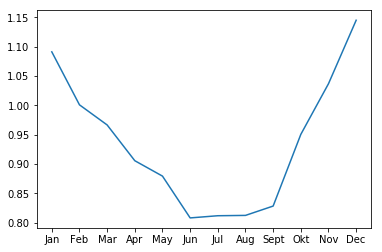

In [204]:
months = np.arange(12)
fig, ax = plt.subplots()
ax.plot(months, mean_absolute_error_per_month[months])
ax.set_xticks(months)
ax.set_xticklabels([month_dict[m] for m in months])
plt.show()

### Plot mean absolute error per hour

In [ ]:
# only interesting for prediction of lead time 1
fig = plt.figure(figsize=(16,10))
mean_error_data_per_run = None


mean_error_per_hour = np.nanmean(mean_error_data_per_run,axis=0)

idx_non_nan_error = np.argwhere(~np.isnan(mean_error_per_hour))
hour = np.array(range(24))

plt.errorbar(hour[idx_non_nan_error], mean_error_per_hour[idx_non_nan_error])
plt.xlabel('Hour of Prediction', fontsize=12)
plt.ylabel('Error [°C]', fontsize=12)
plt.xticks(hour, ["%02d:00" % h for h in hour])
plt.grid()
plt.title('Mean Absolute Error per Hour', fontsize=22)
plt.tight_layout()
#plt.show()
plt.savefig(destination + '/mean_absolute_error_per_hour.png')
plt.close()

### Scatter mean error per height difference against height difference

In [100]:
model_prediction = prediction_error.sel(data = 'prediction')
target = prediction_error.sel(data = 'target')

model_absolute_error_per_sample = np.absolute(model_prediction - target)

In [101]:
height_difference_per_station = station_data.grid_data.sel(feature = 'HH_DIFF').squeeze()

In [102]:
error_per_height_difference = {}
for station in model_absolute_error_per_sample.station:
    station_height_difference = height_difference_per_station.sel(station = station).item()
    station_error = list(model_absolute_error_per_sample.sel(station = station).data)
    try:
        error_per_height_difference[station_height_difference] += station_error
    except:
        error_per_height_difference[station_height_difference] = station_error

In [104]:
mean_error_per_height_difference = []
for item in error_per_height_difference.items():
    height_difference = item[0]
    mean_error = np.nanmean(item[1])
    mean_error_per_height_difference += [(height_difference, mean_error)]
height_difference, height_difference_mean_error = map(np.array, zip(*mean_error_per_height_difference))

In [105]:
sorted_height_difference_indices = np.argsort(height_difference)

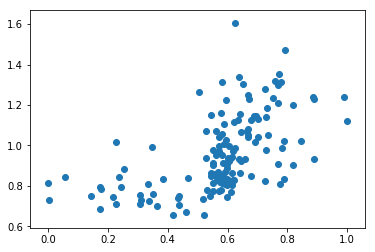

In [106]:
plt.scatter(height_difference[sorted_height_difference_indices], height_difference_mean_error[sorted_height_difference_indices])
plt.show()

## Plot Forecast Skill per Station on Map

#### Calculate mean absolute error and rmse for 3d-baseline

In [22]:
mean_absolute_error_per_station_baseline, rmse_per_station_baseline = getErrorPerStation(distance_metric='3d', baseline='error')

#### Calculate mean RMSE per Station of Model

In [19]:
model_rmse_per_station = None
for run_idx in range(3):
    # load error data of this run
    run_prediction_error = prediction_error['run_%s' % run_idx]
    # get train/test split mapping
    init_type_mapping = run_prediction_error.init_type_mapping
    # filter out test_inits
    test_inits = [i[0] for i in init_type_mapping if i[1] == 'test']
    test_errors = run_prediction_error.sel(init = test_inits)
    # calculate rmse per station
    run_rmse_per_station = np.sqrt(np.nanmean(np.square(test_errors.sel(data = 'difference').data), axis=0))
    try:
        model_rmse_per_station = np.concatenate((model_rmse_per_station, run_rmse_per_station[...,None]), axis=1)
    except:
        model_rmse_per_station = run_rmse_per_station[...,None]
model_mean_prediction_rmse_per_station, model_std_rmse_per_station = np.mean(model_rmse_per_station, axis=1), np.std(model_rmse_per_station, axis=1)

#### Prediction Skill against Baseline 3d

In [23]:
forecast_skill = (1 - model_mean_prediction_rmse_per_station/rmse_per_station_baseline)
largest_improvement_station_idx = forecast_skill.argsort()[::-1]
forecast_skill[largest_improvement_station_idx]

array([0.59373313, 0.56364198, 0.54098671, 0.53695408, 0.53303204,
       0.52523641, 0.52513828, 0.525005  , 0.52073206, 0.51308335,
       0.51118105, 0.50917906, 0.49540786, 0.48073403, 0.47586598,
       0.47551964, 0.46818472, 0.46376577, 0.46061315, 0.45891261,
       0.45691717, 0.44643258, 0.44639648, 0.44314988, 0.44204198,
       0.43897149, 0.43879002, 0.43754358, 0.43510028, 0.43451294,
       0.43400239, 0.43241913, 0.43197388, 0.42997405, 0.42473196,
       0.42468703, 0.42402776, 0.4231141 , 0.41889357, 0.41885726,
       0.4183621 , 0.41799903, 0.41779963, 0.41251732, 0.40841272,
       0.40812547, 0.40663341, 0.40139065, 0.39632741, 0.39628868,
       0.3961972 , 0.39061163, 0.39028499, 0.38606942, 0.38374319,
       0.38362881, 0.38316224, 0.38102146, 0.37819702, 0.37755558,
       0.37740093, 0.37720608, 0.3757254 , 0.37448481, 0.37358665,
       0.37276229, 0.37228524, 0.37024052, 0.37021942, 0.35824506,
       0.35625055, 0.35527381, 0.35517906, 0.35490519, 0.35352

/home/ninow/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


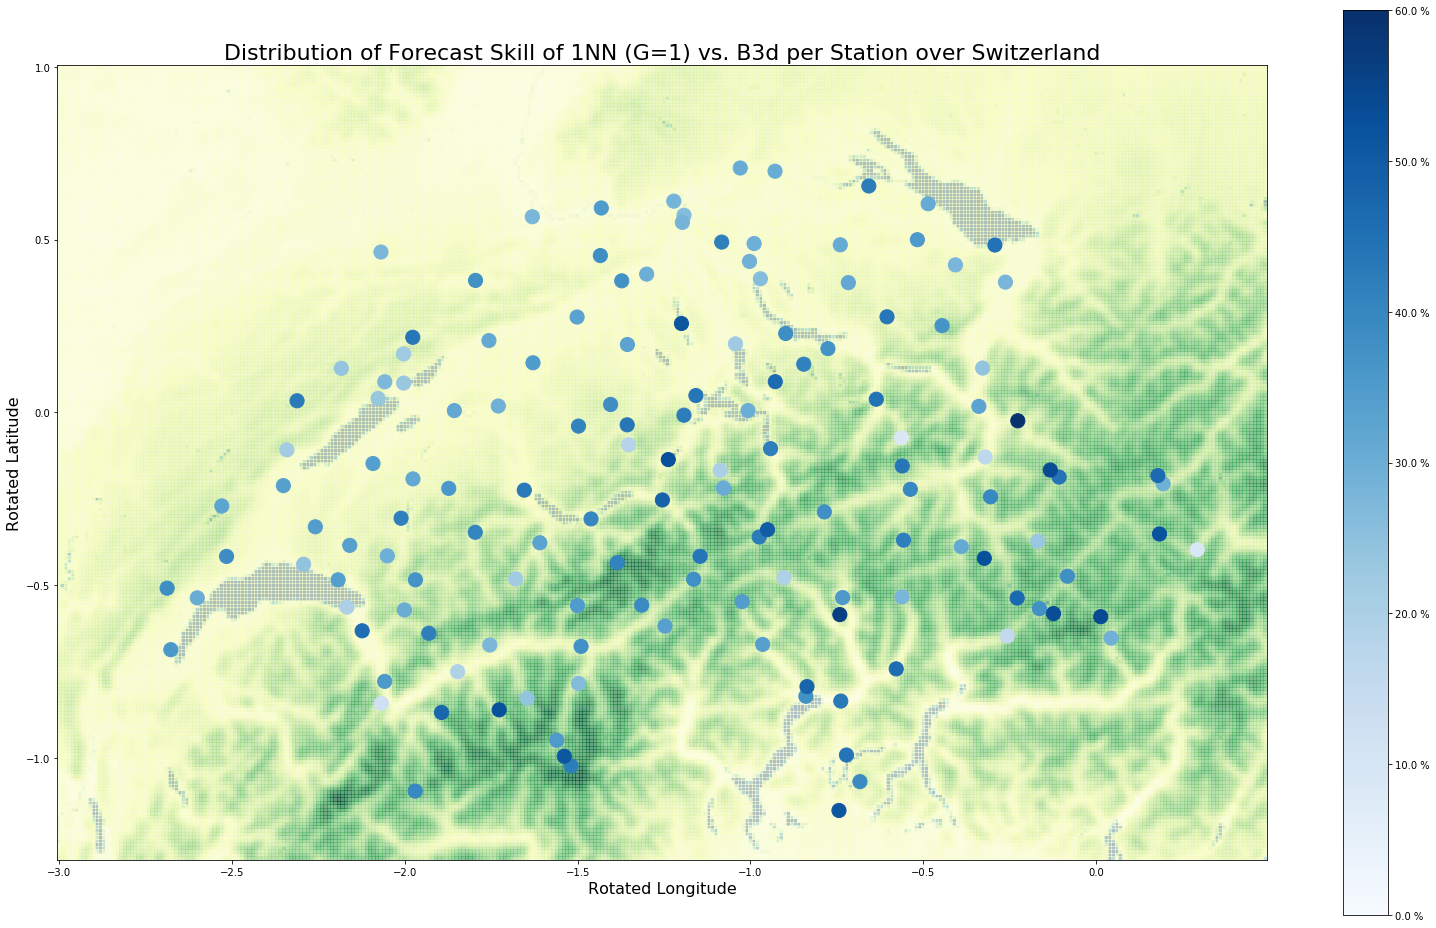

In [40]:
#-------------------------------------------------------------------------------------------------------------------------
# Plot station by error on map
#-------------------------------------------------------------------------------------------------------------------------
rlat_min, rlat_max, rlon_min, rlon_max = -1.3, 1, -3, 0.5

# plot the absolute error of each station in a heat map
fig = plt.figure(figsize=(22,13))
ax = fig.add_subplot(111)
plot_map(ax, rlat_min, rlat_max, rlon_min, rlon_max)
cax = ax.scatter(station_x, station_y, c=forecast_skill, s=200,
                 cmap='Blues', norm=mpl.colors.Normalize(vmin=0, vmax=0.6))
cbar = plt.colorbar(cax, format=ticker.FuncFormatter(lambda x, pos: "%.1f %%" % (x*100)))
ax.set_title('Distribution of Forecast Skill of 1NN (G=1) vs. B3d per Station over Switzerland', fontsize=22)
ax.grid('off')
plt.axis('scaled')
plt.xlabel('Rotated Longitude', fontsize=16)
plt.ylabel('Rotated Latitude', fontsize=16)
plt.tight_layout()
plt.savefig(destination + '/forecast_skill_per_station_on_map.png')
plt.show()
plt.close()

#### Calculate mean absolute error and rmse for station/hour/month-bias corrected baseline

In [41]:
mean_absolute_error_per_station_shmbcb3d, rmse_per_station_shmbcb3d = getErrorPerStation(distance_metric='3d', baseline='mtsbc_error')

#### Prediction Skill against Station/Hour/Month Bias-corrected Baseline 3d

In [42]:
forecast_skill_against_shmbcb3d = (1 - model_mean_prediction_rmse_per_station/rmse_per_station_shmbcb3d)
print(np.mean(forecast_skill_against_shmbcb3d))
largest_improvement_station_shmbcb3d_idx = forecast_skill_against_shmbcb3d.argsort()[::-1]
forecast_skill_against_shmbcb3d[largest_improvement_station_shmbcb3d_idx]

0.23345310639168673


array([0.43218218, 0.38205294, 0.35844194, 0.3548162 , 0.35477157,
       0.35156959, 0.34931929, 0.34585777, 0.34568247, 0.33288501,
       0.33042987, 0.32975129, 0.32761215, 0.31837186, 0.31825651,
       0.31741015, 0.31492024, 0.31456303, 0.31039197, 0.31021273,
       0.29900313, 0.29890828, 0.29781473, 0.29770119, 0.29613459,
       0.29406438, 0.29209332, 0.28770406, 0.28634959, 0.28155667,
       0.28001295, 0.27989902, 0.27624166, 0.2761469 , 0.27414153,
       0.27382809, 0.27241317, 0.27111642, 0.27076076, 0.27066186,
       0.26958048, 0.26900542, 0.26878051, 0.26488254, 0.2642528 ,
       0.26349026, 0.26322652, 0.26311524, 0.26306538, 0.26218176,
       0.26187869, 0.26112356, 0.25907072, 0.25735213, 0.25645694,
       0.25584655, 0.25568529, 0.25458005, 0.25428684, 0.25188307,
       0.25063819, 0.2496299 , 0.24955868, 0.24922432, 0.24772178,
       0.24670186, 0.2465686 , 0.2457969 , 0.24393825, 0.24241782,
       0.24236844, 0.24163124, 0.2415348 , 0.24059352, 0.23976

In [34]:
print(largest_improvement_station_shmbcb3d_idx[0])
stations[largest_improvement_station_shmbcb3d_idx[0]]

141


1024

/home/ninow/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


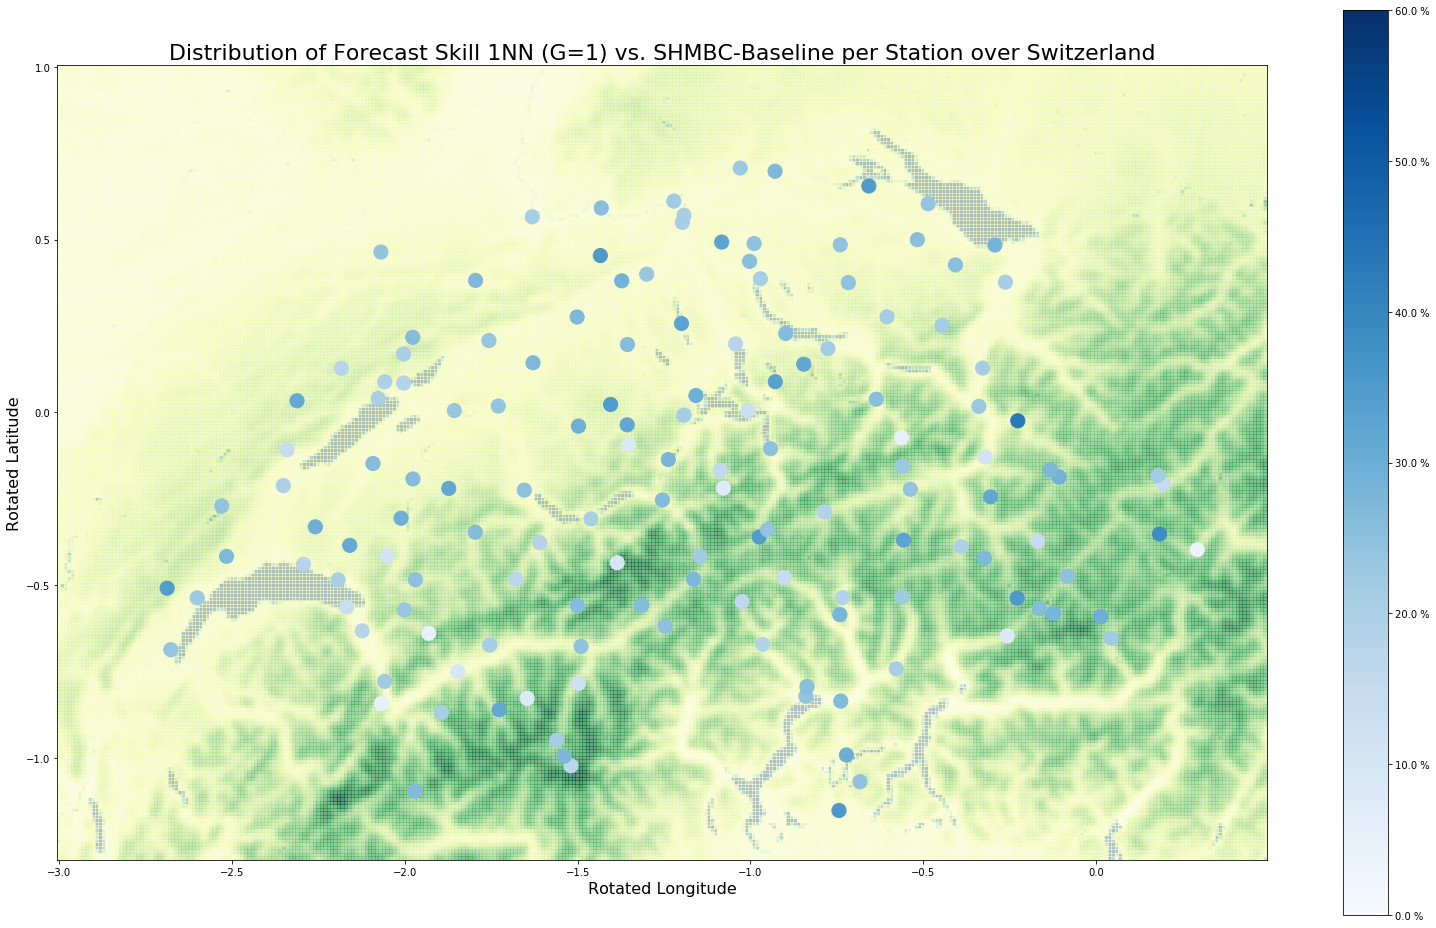

In [43]:
#-------------------------------------------------------------------------------------------------------------------------
# Plot station by error on map
#-------------------------------------------------------------------------------------------------------------------------
rlat_min, rlat_max, rlon_min, rlon_max = -1.3, 1, -3, 0.5

# plot the absolute error of each station in a heat map
fig = plt.figure(figsize=(22,13))
ax = fig.add_subplot(111)
plot_map(ax, rlat_min, rlat_max, rlon_min, rlon_max)
cax = ax.scatter(station_x, station_y, c=forecast_skill_against_shmbcb3d, s=200,
                 cmap='Blues', norm=mpl.colors.Normalize(vmin=0, vmax=0.6))
cbar = plt.colorbar(cax, format=ticker.FuncFormatter(lambda x, pos: "%.1f %%" % (x*100)))
ax.set_title('Distribution of Forecast Skill 1NN (G=1) vs. SHMBC-Baseline per Station over Switzerland', fontsize=22)
ax.grid('off')
plt.axis('scaled')
plt.xlabel('Rotated Longitude', fontsize=16)
plt.ylabel('Rotated Latitude', fontsize=16)
plt.tight_layout()
plt.savefig(destination + '/forecast_skill_shmbcb3d_per_station_on_map.png')
plt.show()
plt.close()

# Forecast skill per hour/month/heigh difference

In [12]:
baseline_prediction = prediction_error.sel(data = 'cosmo')
model_prediction = prediction_error.sel(data = 'prediction')
target = prediction_error.sel(data = 'target')

baseline_absolute_error_per_sample = np.absolute(baseline_prediction - target)
model_absolute_error_per_sample = np.absolute(model_prediction - target)

In [17]:
rmse_difference = model_absolute_error_per_sample - baseline_absolute_error_per_sample

In [19]:
rmse_difference

<xarray.DataArray 'run_0' (init: 7055, station: 144)>
array([[ 0.131553,  0.063592, -0.455109, ..., -2.494343, -0.254032, -0.339274],
       [ 0.21832 , -0.566624,  0.217109, ..., -2.482538,  1.549248, -1.104508],
       [ 0.22874 , -1.240626, -0.381773, ..., -0.353478,  0.102648,  0.587654],
       ...,
       [ 0.485978,  0.116074, -0.117628, ..., -2.286713, -1.638836,  0.194221],
       [-0.341362,  0.268492, -0.418244, ..., -2.544609, -1.467411,  1.16407 ],
       [-1.286159,  0.609851, -0.76062 , ...,  0.017001, -3.169129,  1.898388]])
Coordinates:
  * init     (init) <U8 '15100103' '15100106' '15100109' '15100112' ...
  * station  (station) int32 2 3 4 6 7 8 9 10 11 13 14 15 17 18 19 20 22 23 ...

In [95]:
height_difference_per_station = station_data.grid_data.sel(feature = 'HH_DIFF').squeeze()

In [96]:
error_difference_per_height_difference = {}
for station in rmse_difference.station:
    station_height_difference = height_difference_per_station.sel(station = station).item()
    station_error_difference = list(rmse_difference.sel(station = station).data)
    try:
        error_difference_per_height_difference[station_height_difference] += station_error_difference
    except:
        error_difference_per_height_difference[station_height_difference] = station_error_difference

In [97]:
mean_error_difference_per_height_difference = []
for item in error_difference_per_height_difference.items():
    height_difference = item[0]
    mean_error_difference = np.nanmean(item[1])
    mean_error_difference_per_height_difference += [(height_difference, mean_error_difference)]
height_difference, height_difference_mean_error_difference = map(np.array, zip(*mean_error_difference_per_height_difference))

In [98]:
sorted_height_difference_indices = np.argsort(height_difference)

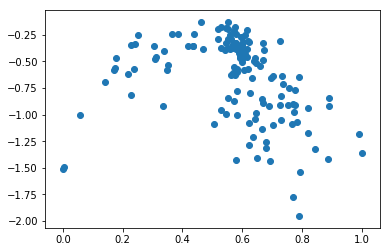

In [99]:
plt.scatter(height_difference[sorted_height_difference_indices], height_difference_mean_error[sorted_height_difference_indices])
plt.show()

(143,)

## Plot Error per Prediction Hour

In [14]:
# only interesting for prediction of lead time 1
fig = plt.figure(figsize=(16,10))
mean_error_data_per_run = None
for run in range(3):
    error_data = error_statistic_per_run_dict_2d['run_%s' % run].error_statistic.sel(error_type = 'error')
    mean_error_data = np.nanmean(np.absolute(error_data), axis=(0,1,2,4,5))
    try:
        mean_error_data_per_run = np.concatenate((mean_error_data_per_run, mean_error_data[None,:]), axis=0)
    except:
        mean_error_data_per_run = mean_error_data[None,:]

mean_error_per_hour = np.nanmean(mean_error_data_per_run,axis=0)

idx_non_nan_error = np.argwhere(~np.isnan(mean_error_per_hour))
hour = np.array(range(24))

plt.errorbar(hour[idx_non_nan_error], mean_error_per_hour[idx_non_nan_error])
plt.xlabel('Hour of Prediction', fontsize=12)
plt.ylabel('Error [°C]', fontsize=12)
plt.xticks(hour, ["%02d:00" % h for h in hour])
plt.grid()
plt.title('Mean Absolute Error per Hour', fontsize=22)
plt.tight_layout()
#plt.show()
plt.savefig(destination + '/mean_absolute_error_per_hour.png')
plt.close()

##### Same plot for each station seperately to see stational difference of diurnal effects

In [95]:
# only interesting for prediction of lead time 1
fig = plt.figure(figsize=(16,10))
mean_error_data_per_run = None
for run in range(3):
    error_data = error_statistic_per_run_dict_2d['run_%s' % run].error_statistic.sel(error_type = 'error', lead = 1)
    mean_error_data = np.nanmean(np.absolute(error_data), axis=(3,4))
    try:
        mean_error_data_per_run = np.concatenate((mean_error_data_per_run, mean_error_data), axis=0)
    except:
        mean_error_data_per_run = mean_error_data

mean_error_per_hour = np.nanmean(mean_error_data_per_run,axis=0)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


In [101]:
per_station_statistic = np.zeros((144,5))
for station_idx, station_error in enumerate(mean_error_per_hour):
    max_hour = np.nanargmax(station_error)
    max_error = station_error[max_hour]
    min_hour = np.nanargmin(station_error)
    min_error = station_error[min_hour]
    difference = max_error - min_error
    per_station_statistic[station_idx] = np.array([max_hour, max_error, min_hour, min_error, difference])

In [106]:
max_diurnal_effected_stations = np.argsort(per_station_statistic[:,4])[::-1]

128 La Brévine
103 Mottec
114 Lachen / Galgenen


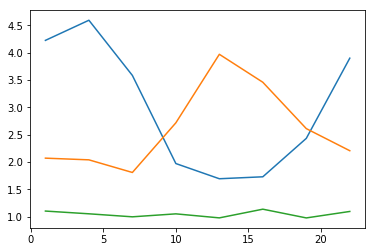

In [120]:
for station_idx in max_diurnal_effected_stations[[0,2,-1]]:
    print(station_idx, station_names[station_idx].item())
    mask = np.isfinite(mean_error_per_hour[station_idx])
    plt.plot(np.arange(24)[mask],mean_error_per_hour[station_idx][mask])
plt.show()

In [99]:
max_diurnal_effected_stations

array([2, 1, 4, 3, 0])

## Plot Error per Month

In [ ]:
fig = plt.figure(figsize=(16,10))
mean_error_data_per_run = None
for run in [0,1,2]:
    error_data = error_statistic_per_run_dict_2d['run_%s' % run].error_statistic.sel(error_type = 'error')
    mean_error_data = np.nanmean(np.absolute(error_data), axis=(0,1,2,3,5))
    error_months = error_data.month.data
    if len(error_months) < 12:
        data_container = np.empty((12,))
        data_container.fill(np.nan)
        for m_idx, m in enumerate(error_months):
            data_container[m] = mean_error_data[m_idx]
        mean_error_data = data_container
    try:
        mean_error_data_per_run = np.concatenate((mean_error_data_per_run, mean_error_data[None,:]), axis=0)
    except:
        mean_error_data_per_run = mean_error_data[None,:]

mean_error_per_month = np.nanmean(mean_error_data_per_run,axis=0)
idx_non_nan_error = np.argwhere(~np.isnan(mean_error_per_month))
month = np.array(range(12))

plt.plot(month[idx_non_nan_error], mean_error_per_month[idx_non_nan_error])
plt.xlabel('Month of Prediction', fontsize=12)
plt.ylabel('Error [°C]', fontsize=12)
plt.xticks(month, [month_dict[m] for m in month])
plt.grid()
plt.title('Mean Absolute Error per Month', fontsize=22)
plt.tight_layout()
#plt.show()
plt.savefig(destination + '/mean_absolute_error_per_month.png')
plt.show()

## Plot results of all baselines

In [ ]:
fig = plt.figure(figsize=(16,10))
# only plot error from lead time = 1
T=1
# gather error data for 2d baselines
mean_error_data_per_run_2d = None
for run in [0,1,2]:
    error_data = error_statistic_per_run_dict_2d['run_%s' % run].error_statistic.sel(lead = T)
    mean_error_data = np.sqrt(np.nanmean(np.square(error_data), axis=(0,1,2,3,5)))
    try:
        mean_error_data_per_run_2d = np.concatenate((mean_error_data_per_run_2d, mean_error_data[None,:]), axis=0)
    except:
        mean_error_data_per_run_2d = mean_error_data[None,:]
        
# gather error data for 3d baselines
mean_error_data_per_run_3d = None
for run in [0,1,2]:
    error_data = error_statistic_per_run_dict_3d['run_%s' % run].error_statistic.sel(lead = T)
    mean_error_data = np.sqrt(np.nanmean(np.square(error_data), axis=(0,1,2,3,5)))
    try:
        mean_error_data_per_run_3d = np.concatenate((mean_error_data_per_run_3d, mean_error_data[None,:]), axis=0)
    except:
        mean_error_data_per_run_3d = mean_error_data[None,:]
        
# concatenate 2d and 3d errors
mean_error_per_baseline = np.nanmean(np.concatenate((mean_error_data_per_run_2d, mean_error_data_per_run_3d), axis=1), axis=0)

In [ ]:
# concatenate 3NN baseline error
error_3NN = []
for i in range(3):
    error_3NN += [np.sqrt(np.nanmean(np.square(error_data_3nn['run_%s' % i][T])))]
print(error_3NN)
mean_error_per_baseline = np.concatenate((mean_error_per_baseline, np.nanmean(error_3NN)[None]))

In [ ]:
# concatenate 10NN baseline error
error_10NN = []
for i in range(3):
    error_10NN += [np.sqrt(np.nanmean(np.square(error_data_10nn['run_%s' % i][T])))]
print(error_10NN)
mean_error_per_baseline = np.concatenate((mean_error_per_baseline, np.nanmean(error_10NN)[None]))

In [ ]:
baseline_dict = {0:'B2d', 1:'SBCB2d', 2:'SHBCB2d', 3:'SHMBCB2d', 4:'B3d', 5:'SBCB3d', 6:'SHBCB3d', 7:'SHMBCB3d', 8:'3-NN', 9:'10-NN'}

In [ ]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%.3f' % height,
                ha='center', va='bottom')

fig, ax = plt.subplots(figsize=(16,10))

x_ticks = np.array(list(range(len(mean_error_per_baseline))))
sorted_idx = np.argsort(mean_error_per_baseline)
rects = plt.bar(x_ticks, mean_error_per_baseline[sorted_idx], width=0.6)
plt.xlabel('Baseline')
plt.ylabel('RMSE [°C]')
plt.xticks(x_ticks, [baseline_dict[b] for b in sorted_idx])
plt.yticks(np.arange(0, 2.5, 0.1))
autolabel(rects)
    
plt.grid()
plt.title('Root Mean Squared Error per Baseline Variant', fontsize=22)
plt.tight_layout()
plt.savefig(destination + '/mean_absolute_error_per_baseline_variant.png')
plt.show()

## Plot Train / Test distribution

In [ ]:
train_test_splits = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/train_test_folds_r_3_sl_24_tfw_66_tf_0.1_series_0_s_23021.pkl', 'rb'))

In [ ]:
def split_year_intervals(train, test):
    # calculate first and last data sample
    max_date = max(datetime.strptime(train[train.shape[0] - 1], '%y%m%d%H'),
                   datetime.strptime(test[test.shape[0] - 1], '%y%m%d%H'))
    min_date = min(datetime.strptime(train[0], '%y%m%d%H'), datetime.strptime(test[0], '%y%m%d%H'))
    diff_days = (max_date - min_date).days

    # number of years we have data
    n_years = int(diff_days / 365) + 1

    # transform datetimes into days since the first observation
    train_days = []
    for d in train:
        train_days += [(datetime.strptime(d, '%y%m%d%H') - min_date).days]

    test_days = []
    for d in test:
        test_days += [(datetime.strptime(d, '%y%m%d%H') - min_date).days]

    # calculate ranges for yearly plots
    ranges = [x * 365 for x in range(n_years + 1)]
    split_train = [[] for y in range(n_years)]
    split_test = [[] for y in range(n_years)]

    for x in train_days:
        split = int(x / 365)
        split_train[split] += [x]

    for x in test_days:
        split = int(x / 365)
        split_test[split] += [x]

    return ranges, split_train, split_test

for run in range(3):
    train = np.squeeze(np.array([item[1] for item in train_test_splits[run][0]]))
    train.sort()
    test = np.squeeze(np.array([item[1] for item in train_test_splits[run][1]]))
    test.sort()

    # generate data splits by year
    ranges, split_train, split_test = split_year_intervals(train, test)

    # get string representation of YYYY-MM-DD for each sample
    first_init_string = str(np.min([int(i) for i in train] + [int(i) for i in test]))
    first_init = datetime(year=int(first_init_string[:2]) + 2000,
                          month=int(first_init_string[2:4]),
                          day=int(first_init_string[4:6]),
                         hour=int(first_init_string[6:8]))
    xticks = [str(first_init + timedelta(hours = sample_idx*3))[:10] for sample_idx in range(0,3*365*8)]

    # generate histograms
    n_subplots = len(split_train)
    fig, axes = plt.subplots(n_subplots, figsize=(30, 15))
    for year in range(n_subplots):
        axes[year].hist(split_train[year], 365, color='g', range=(ranges[year], ranges[year + 1]),
                        label='Training Samples')
        axes[year].set_xlim([ranges[year], ranges[year + 1]])
        ax2 = axes[year].twinx()
        ax2.hist(split_test[year], 365, color='r', range=(ranges[year], ranges[year + 1]), label='Test Samples')
        axes[year].set_ylabel('Occurences')

    axes[n_subplots - 1].set_xlabel('Initialization')
    handles_train, labels_train = axes[n_subplots - 1].get_legend_handles_labels()
    handles_test, labels_test = ax2.get_legend_handles_labels()
    axes[n_subplots - 1].legend([handles_train[0], handles_test[0]], [labels_train[0], labels_test[0]])

    for year in range(n_subplots):
        plt.sca(axes[year])
        xtick_pos = np.arange(year*365,(year+1)*365,14)
        plt.xticks(xtick_pos, xticks[365*8*year:365*8*(year+1)][::14*8])
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.suptitle('Distribution of Train and Test Samples for Fold %s' % run, fontsize=28)
    plt.show()
    plt.close()

## Plot K-Fold Station Cross Validation Results

In [ ]:
reduced_ds

In [ ]:
np.nanmean(all_data.per_station_error.data[1,:,0] - all_data.per_station_error.data[1,:,1])

-0.3175968464715194


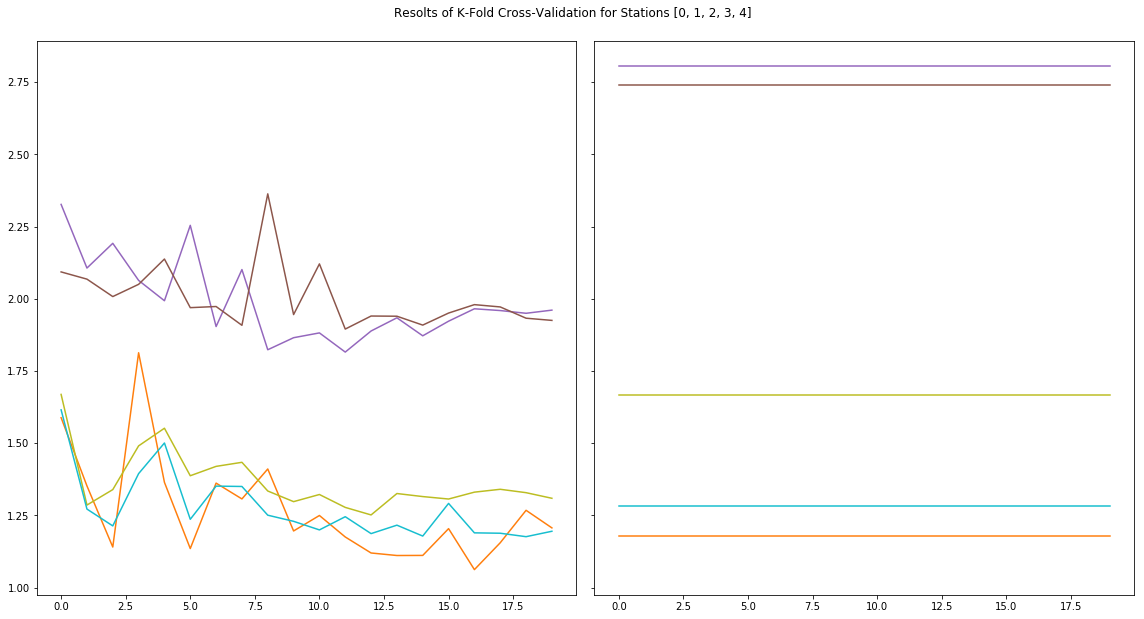

-0.23266836565606158


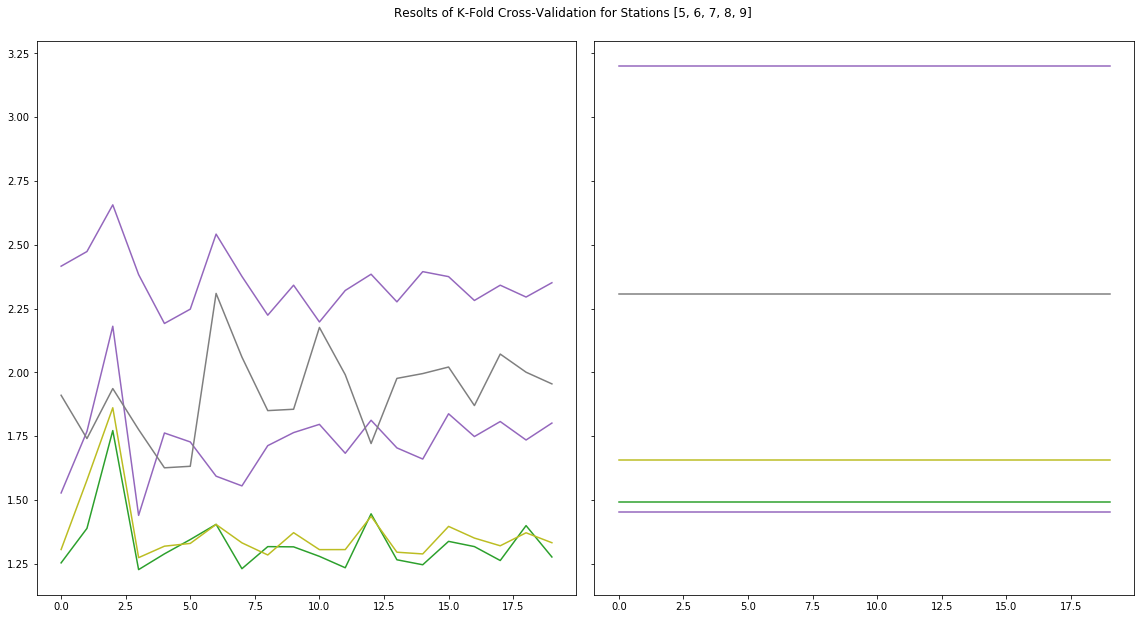

-0.07017812373392288


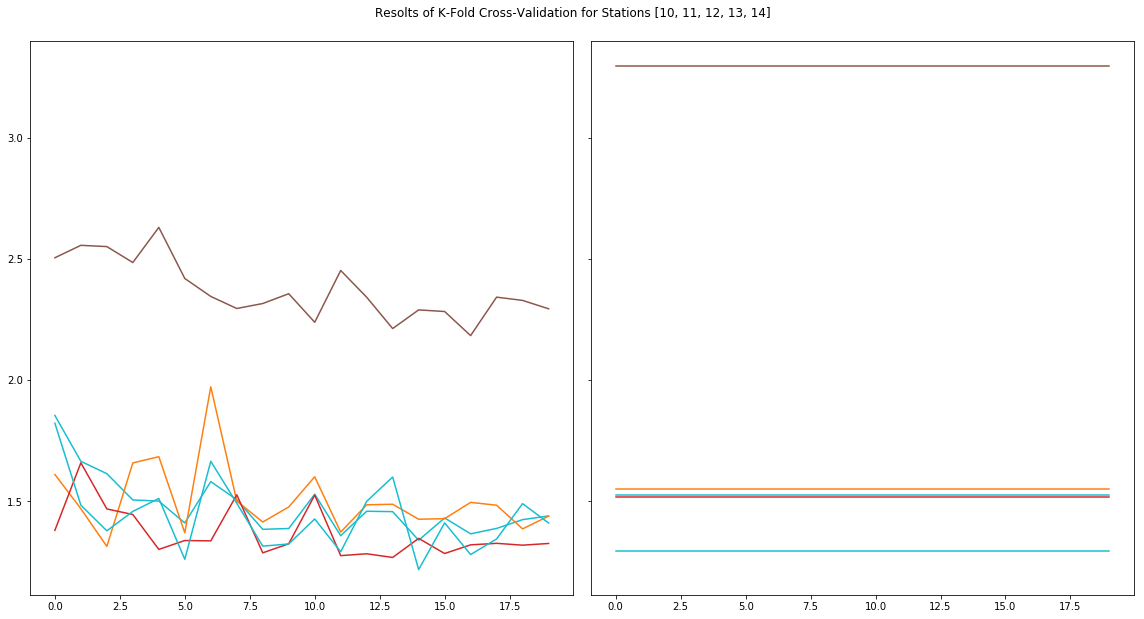

-0.19238228906071292


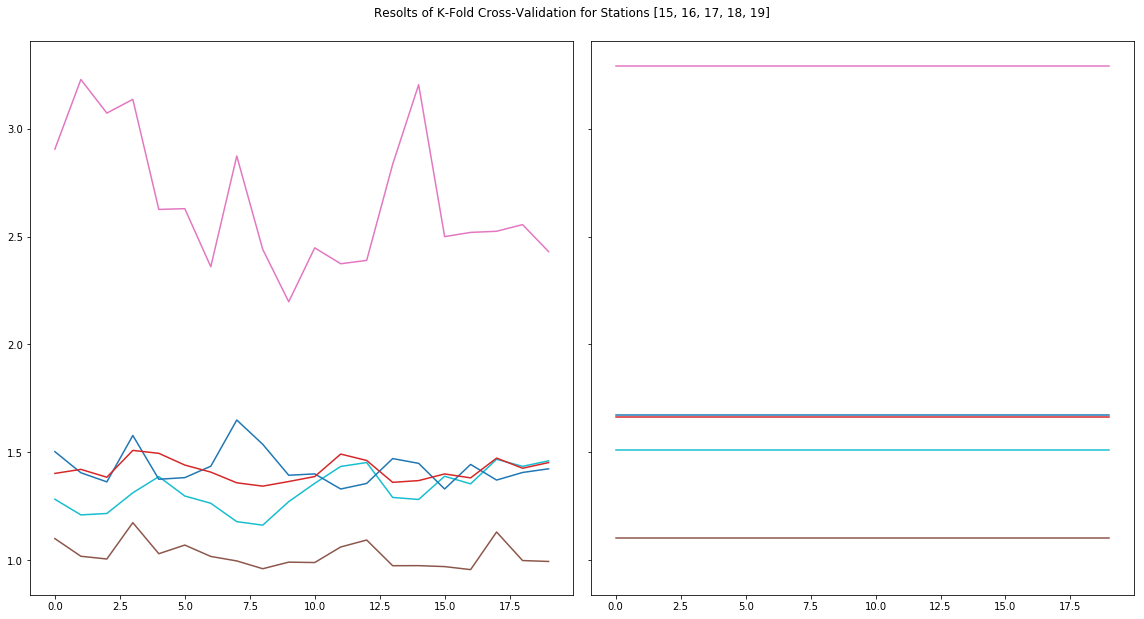

-0.09426892425696191


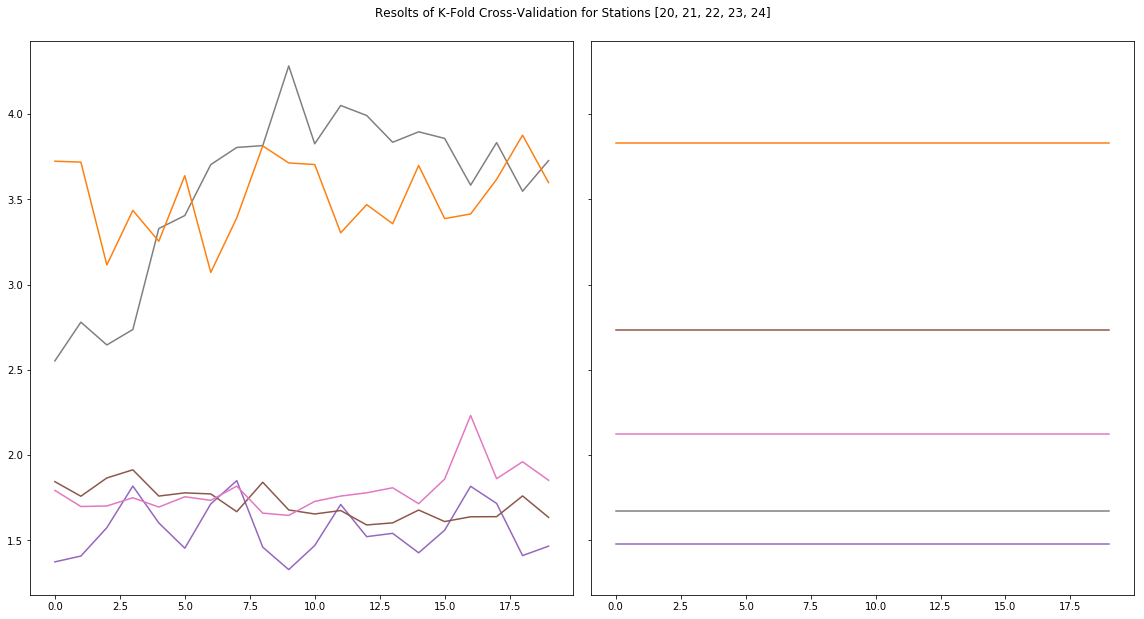

0.10291603656992492


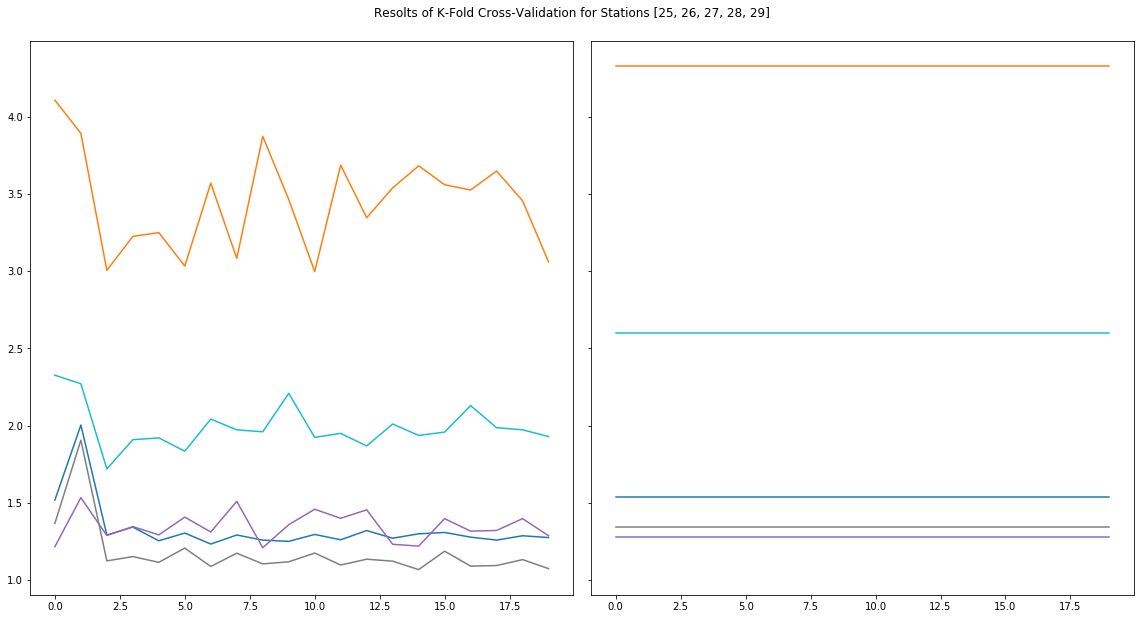

-0.3362098358016245


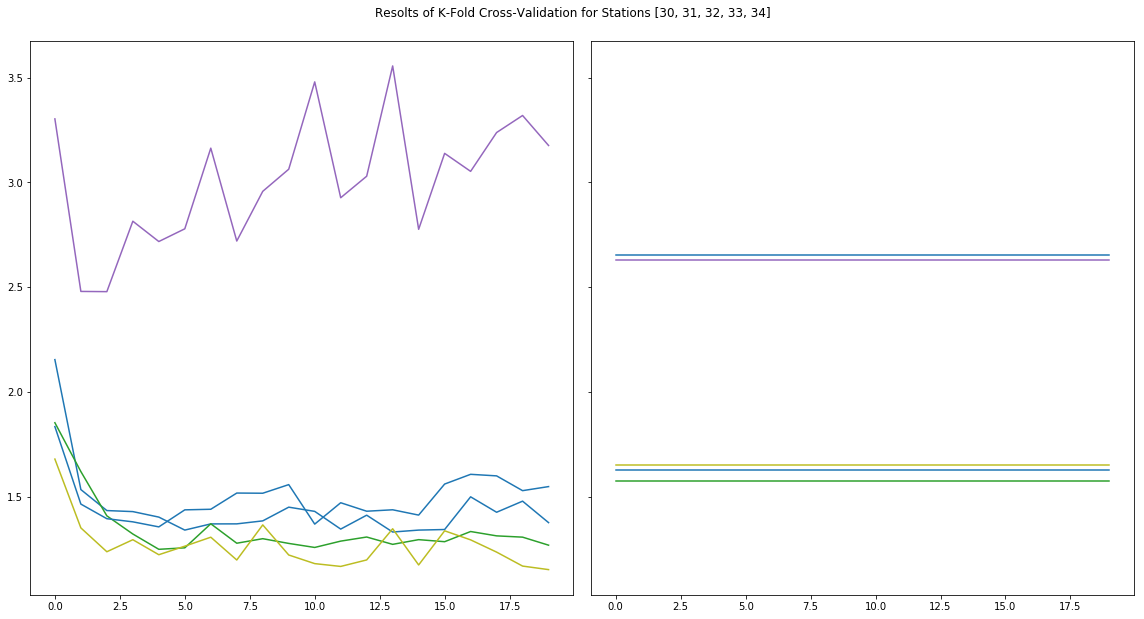

0.27215627446715684


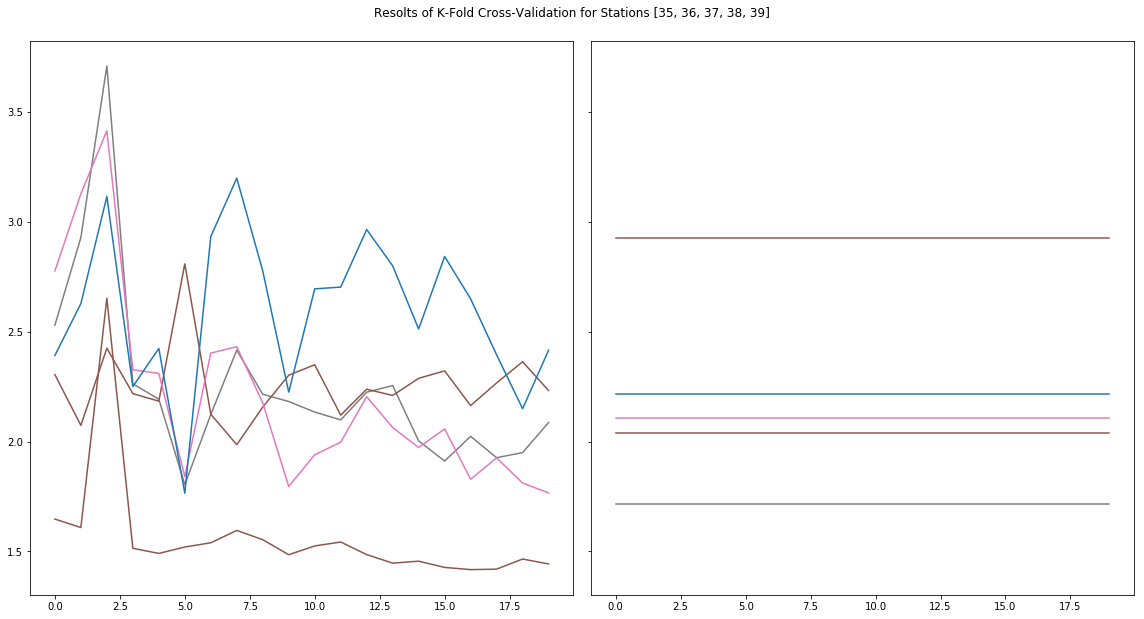

-0.5697708079310192


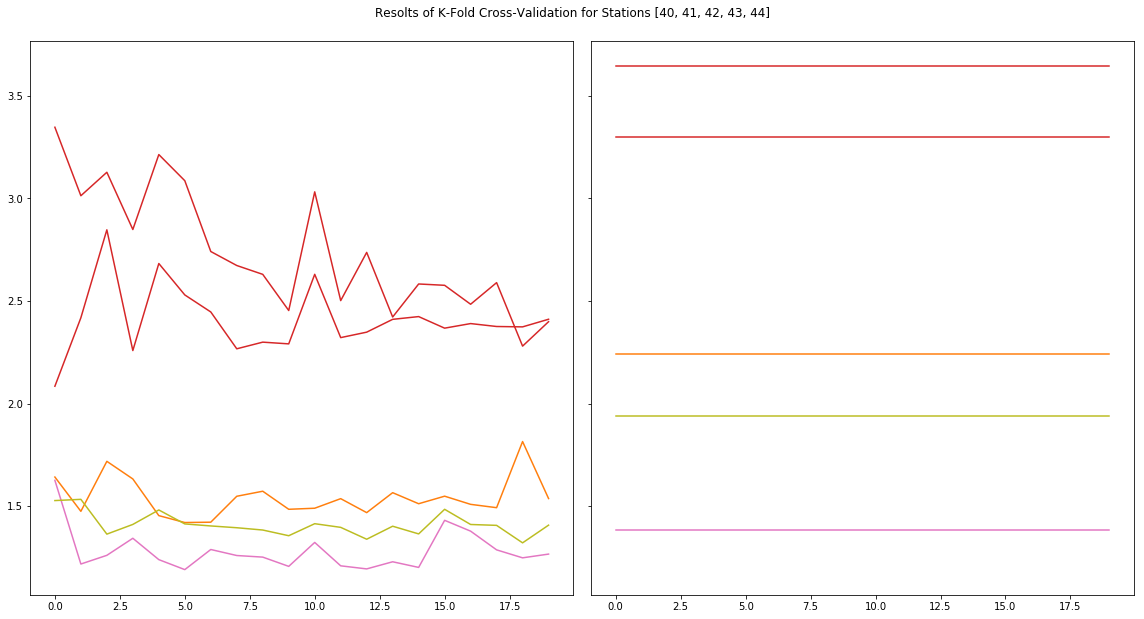

-0.541529732831472


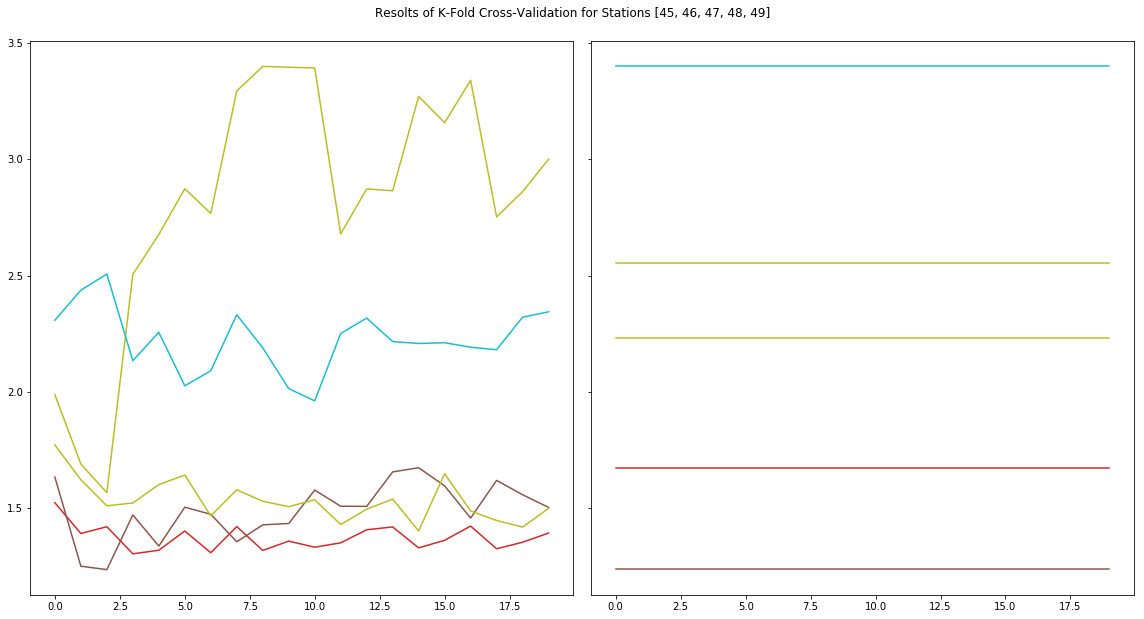

-0.3071251320080555


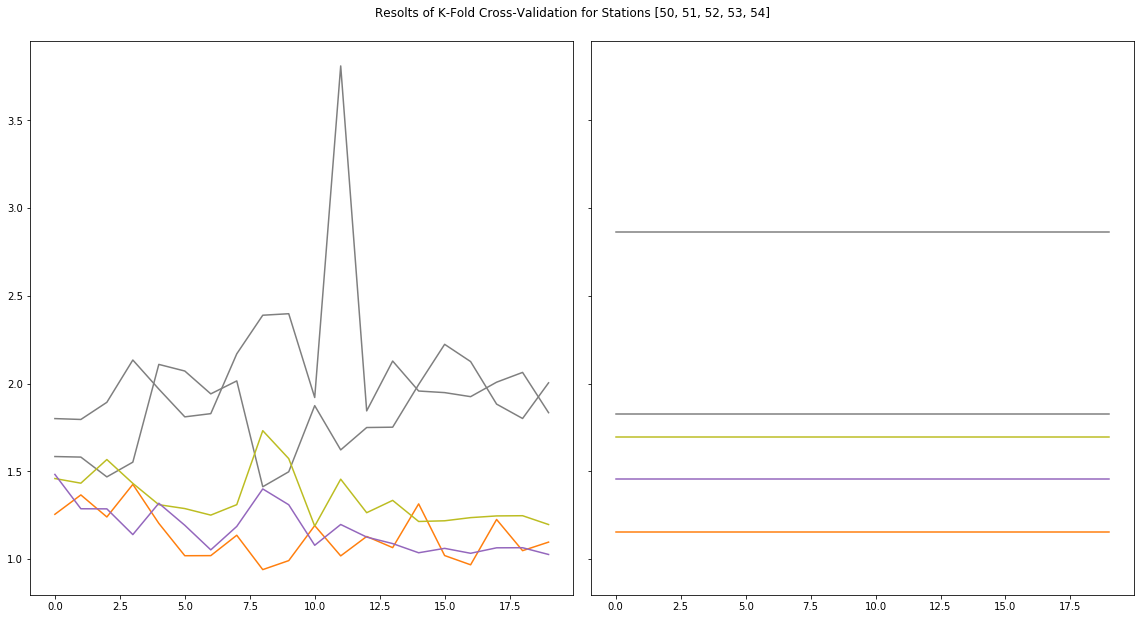

<xarray.Dataset>
Dimensions:            ()
Data variables:
    per_station_error  float64 1.952

In [61]:
for first_station in np.arange(0,55,5):
    ds = pkl.load(open('/home/ninow/master_thesis/code/project/results/runs/spatial_generalization_experiment/experiment/first_station_%s/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_21/rmse_per_station.pkl' % first_station,'rb'))
    
    # only keep entries for existing stations
    reduced_ds = ds.sel(run = 0, station = stations)
    
    print(np.nanmean(reduced_ds.data[1,:,0] - reduced_ds.data[1,:,1]))
    
    fig, axes = plt.subplots(1,2, figsize=(16,9), sharex=True, sharey=True)
    axes[0].plot(reduced_ds.data[:,:,0])
    axes[1].plot(reduced_ds.data[:,:,1])
    fig.suptitle('Resolts of K-Fold Cross-Validation for Stations %s' % list(range(first_station, first_station+5)))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()
    

    try:
        all_data = xr.merge([all_data, reduced_ds.to_dataset(name='per_station_error')], compat='no_conflicts')
    except:
        all_data = reduced_ds.to_dataset(name='per_station_error')

In [68]:
np.mean(all_data.per_station_error, axis=1)

<xarray.DataArray 'per_station_error' (epoch: 20, error: 2)>
array([[1.934715, 2.088896],
       [1.881018, 2.088896],
       [1.878062, 2.088896],
       [1.813482, 2.088896],
       [1.808824, 2.088896],
       [1.763639, 2.088896],
       [1.821419, 2.088896],
       [1.841098, 2.088896],
       [1.818488, 2.088896],
       [1.784782, 2.088896],
       [1.81781 , 2.088896],
       [1.804386, 2.088896],
       [1.796271, 2.088896],
       [1.802653, 2.088896],
       [1.785784, 2.088896],
       [1.815402, 2.088896],
       [1.793871, 2.088896],
       [1.798348, 2.088896],
       [1.78833 , 2.088896],
       [1.768824, 2.088896]])
Coordinates:
  * epoch    (epoch) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
    run      int64 0
  * error    (error) <U5 'model' 'cosmo'

In [64]:
all_data

<xarray.Dataset>
Dimensions:            (epoch: 20, error: 2, station: 144)
Coordinates:
  * epoch              (epoch) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
    run                int64 0
  * station            (station) int64 2 3 4 6 7 8 9 10 11 13 14 15 17 18 19 ...
  * error              (error) <U5 'model' 'cosmo'
Data variables:
    per_station_error  (epoch, station, error) float64 nan nan 1.255 1.154 ...

In [3]:
# load prediction error from prediction run
prediction_error_1nn = pkl.load(open('/home/ninow/master_thesis/code/project/results/runs/knn_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/model_run_error.pkl', 'rb'))

In [13]:
rmse_mean = np.sqrt(np.nanmean(np.square(prediction_error_1nn.run_0.sel(data = 'difference')), axis=1))
best_init = np.argmin(rmse_mean)
rmse_mean[best_init]

0.5361502755587562

In [11]:
prediction_error_1nn.run_0.isel(init = best_init)

<xarray.DataArray 'run_0' (station: 144, data: 4)>
array([[ 1.194811e+01,  1.237588e+01,  1.210000e+01, -1.518946e-01],
       [ 1.050168e+01,  1.051943e+01,  1.050000e+01,  1.681328e-03],
       [ 1.216067e+01,  1.225088e+01,  1.230000e+01, -1.393337e-01],
       ...,
       [ 1.079430e+01,  1.066592e+01,  1.080000e+01, -5.699158e-03],
       [ 9.515572e+00,  8.579980e+00,  9.600000e+00, -8.442879e-02],
       [ 1.254107e+01,  1.249111e+01,  1.230000e+01,  2.410736e-01]])
Coordinates:
    init     <U8 '16061903'
  * station  (station) int32 2 3 4 6 7 8 9 10 11 13 14 15 17 18 19 20 22 23 ...
  * data     (data) <U10 'prediction' 'cosmo' 'target' 'difference'
Attributes:
    init_type_mapping:  [('15100103', 'test'), ('15100106', 'test'), ('151001...